<a href="https://colab.research.google.com/github/eghib22/Store-Sales-Forecasting/blob/main/model_experiment_XGBoost_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle
! pip install dagshub

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ekaterineghibradze","key":"b1414052fbae86987efff2083c8dcbd1"}'}

In [5]:
!mv "kaggle.json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!ls -l ~/.kaggle/

total 4
-rw------- 1 root root 74 Jul 15 19:02 kaggle.json


In [7]:
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting

walmart-recruiting-store-sales-forecasting.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
! unzip walmart-recruiting-store-sales-forecasting

Archive:  walmart-recruiting-store-sales-forecasting.zip
replace features.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: features.csv.zip        
replace sampleSubmission.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sampleSubmission.csv.zip  
replace stores.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: stores.csv              
replace test.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv.zip            
replace train.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv.zip           


In [9]:
!unzip '*.csv.zip'

Archive:  sampleSubmission.csv.zip
replace sampleSubmission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sampleSubmission.csv    

Archive:  features.csv.zip
replace features.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: features.csv            

Archive:  test.csv.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: yy
  inflating: test.csv                

Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               

4 archives were successfully processed.


In [10]:
!unzip '*.csv.zip'

Archive:  sampleSubmission.csv.zip
replace sampleSubmission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sampleSubmission.csv    

Archive:  features.csv.zip
replace features.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: features.csv            

Archive:  test.csv.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: yy
  inflating: test.csv                

Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               

4 archives were successfully processed.


In [11]:
import dagshub
dagshub.init(repo_owner='eghib22', repo_name='Store-Sales-Forecasting', mlflow=True)

Accessing as eghib22

Initialized MLflow to track repo "eghib22/Store-Sales-Forecasting"

Repository eghib22/Store-Sales-Forecasting initialized!

In [12]:
import pandas as pd

# Load the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
features = pd.read_csv('features.csv')
stores = pd.read_csv('stores.csv')
sample_submission = pd.read_csv('sampleSubmission.csv')

# Explore the data
print("Train shape:", train.shape)
print(train.head())
print(train.columns)

print("\nTest shape:", test.shape)
print(test.head())
print(test.columns)

print("\nFeatures shape:", features.shape)
print(features.head())
print(features.columns)

print("\nStores shape:", stores.shape)
print(stores.head())
print(stores.columns)

print("\nSample Submission shape:", sample_submission.shape)
print(sample_submission.head())
print(sample_submission.columns)

Train shape: (421570, 5)
   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False
Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday'], dtype='object')

Test shape: (115064, 4)
   Store  Dept        Date  IsHoliday
0      1     1  2012-11-02      False
1      1     1  2012-11-09      False
2      1     1  2012-11-16      False
3      1     1  2012-11-23       True
4      1     1  2012-11-30      False
Index(['Store', 'Dept', 'Date', 'IsHoliday'], dtype='object')

Features shape: (8190, 12)
   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        3

In [13]:
# Merge train and test with features and stores
train_merged = pd.merge(train, features, on=['Store', 'Date'], how='left')
train_merged = pd.merge(train_merged, stores, on='Store', how='left')

test_merged = pd.merge(test, features, on=['Store', 'Date'], how='left')
test_merged = pd.merge(test_merged, stores, on='Store', how='left')

# Convert Date to datetime
train_merged['Date'] = pd.to_datetime(train_merged['Date'])


In [14]:
# Split
train_data = train_merged[train_merged['Date'] < '2012-01-01']
val_data = train_merged[(train_merged['Date'] >= '2012-01-01') & (train_merged['Date'] < '2012-07-01')]
test_data = train_merged[train_merged['Date'] >= '2012-07-01']

print("Train:", train_data.shape)
print("Validation:", val_data.shape)
print("Test (local):", test_data.shape)

Train: (294132, 17)
Validation: (77110, 17)
Test (local): (50328, 17)


<class 'pandas.core.frame.DataFrame'>
Index: 294132 entries, 0 to 421526
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         294132 non-null  int64         
 1   Dept          294132 non-null  int64         
 2   Date          294132 non-null  datetime64[ns]
 3   Weekly_Sales  294132 non-null  float64       
 4   IsHoliday_x   294132 non-null  bool          
 5   Temperature   294132 non-null  float64       
 6   Fuel_Price    294132 non-null  float64       
 7   MarkDown1     23700 non-null   float64       
 8   MarkDown2     20154 non-null   float64       
 9   MarkDown3     23116 non-null   float64       
 10  MarkDown4     21042 non-null   float64       
 11  MarkDown5     23994 non-null   float64       
 12  CPI           294132 non-null  float64       
 13  Unemployment  294132 non-null  float64       
 14  IsHoliday_y   294132 non-null  bool          
 15  Type          294132 n

<Axes: >

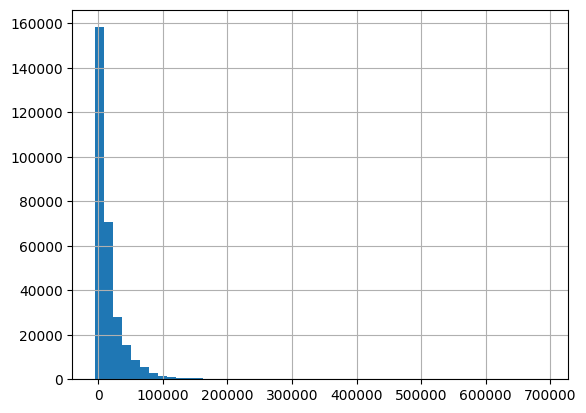

In [15]:
print(train_data.info())
print(train_data.describe())
print(train_data.isnull().sum())
train_data['Weekly_Sales'].hist(bins=50)

In [16]:
!pip install mlflow

y


In [17]:
# import numpy as np
# import pandas as pd
# import xgboost as xgb
# from sklearn.model_selection import TimeSeriesSplit
# from sklearn.metrics import make_scorer, mean_absolute_error
# from sklearn.preprocessing import FunctionTransformer
# import joblib
# import mlflow
# from datetime import datetime, timedelta

# # --- Enhanced Preprocessing with Time Series Features ---
# def enhanced_preprocess(df, is_train=True):
#     df = df.copy()

#     # Ensure Date is datetime
#     if 'Date' not in df.columns:
#         raise ValueError("Date column is required")

#     if not pd.api.types.is_datetime64_any_dtype(df['Date']):
#         df['Date'] = pd.to_datetime(df['Date'])

#     # Sort by Store and Date for proper time series ordering
#     df = df.sort_values(['Store', 'Date']).reset_index(drop=True)

#     # Basic preprocessing
#     type_map = {'A': 0, 'B': 1, 'C': 2}
#     df['Type'] = df['Type'].map(type_map)

#     if 'IsHoliday_x' in df.columns:
#         df['IsHoliday'] = df['IsHoliday_x'].astype(int)
#         df = df.drop(columns=['IsHoliday_x', 'IsHoliday_y'])
#     elif 'IsHoliday' in df.columns:
#         df['IsHoliday'] = df['IsHoliday'].astype(int)

#     markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
#     for col in markdown_cols:
#         if col in df.columns:
#             df[col] = df[col].fillna(0)

#     # Enhanced time features
#     df['Year'] = df['Date'].dt.year
#     df['Month'] = df['Date'].dt.month
#     df['Week'] = df['Date'].dt.isocalendar().week.astype(int)
#     df['Day'] = df['Date'].dt.day
#     df['DayOfWeek'] = df['Date'].dt.dayofweek
#     df['IsMonthStart'] = df['Date'].dt.is_month_start.astype(int)
#     df['IsMonthEnd'] = df['Date'].dt.is_month_end.astype(int)
#     df['IsWeekend'] = df['Date'].dt.dayofweek.isin([5, 6]).astype(int)
#     df['Quarter'] = df['Date'].dt.quarter
#     df['DayOfYear'] = df['Date'].dt.dayofyear
#     df['WeekOfYear'] = df['Date'].dt.isocalendar().week

#     # Cyclical encoding for better time representation
#     df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
#     df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
#     df['Week_sin'] = np.sin(2 * np.pi * df['Week'] / 52)
#     df['Week_cos'] = np.cos(2 * np.pi * df['Week'] / 52)
#     df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
#     df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

#     # Time-based lag features (only for training to avoid data leakage)
#     if is_train and 'Weekly_Sales' in df.columns:
#         df = create_lag_features(df)

#     return df

# def create_lag_features(df):
#     """Create lag features for time series without data leakage"""
#     df_with_lags = df.copy()

#     # Sort by Store and Date
#     df_with_lags = df_with_lags.sort_values(['Store', 'Date']).reset_index(drop=True)

#     # Create lag features for each store
#     for store in df_with_lags['Store'].unique():
#         store_mask = df_with_lags['Store'] == store
#         store_data = df_with_lags[store_mask].copy()

#         # Lag features (1, 2, 4, 8, 12 weeks back)
#         lag_periods = [1, 2, 4, 8, 12]
#         for lag in lag_periods:
#             df_with_lags.loc[store_mask, f'Sales_lag_{lag}'] = store_data['Weekly_Sales'].shift(lag)

#         # Rolling statistics (avoid data leakage by using only past data)
#         for window in [4, 8, 12]:
#             df_with_lags.loc[store_mask, f'Sales_rolling_mean_{window}'] = (
#                 store_data['Weekly_Sales'].shift(1).rolling(window=window, min_periods=1).mean()
#             )
#             df_with_lags.loc[store_mask, f'Sales_rolling_std_{window}'] = (
#                 store_data['Weekly_Sales'].shift(1).rolling(window=window, min_periods=1).std()
#             )

#         # Trend features
#         df_with_lags.loc[store_mask, 'Sales_trend_4w'] = (
#             store_data['Weekly_Sales'].shift(1) - store_data['Weekly_Sales'].shift(5)
#         )
#         df_with_lags.loc[store_mask, 'Sales_trend_8w'] = (
#             store_data['Weekly_Sales'].shift(1) - store_data['Weekly_Sales'].shift(9)
#         )

#     # Fill NaN values for lag features
#     lag_cols = [col for col in df_with_lags.columns if 'lag_' in col or 'rolling_' in col or 'trend_' in col]
#     for col in lag_cols:
#         df_with_lags[col] = df_with_lags[col].fillna(df_with_lags[col].median())

#     return df_with_lags

# # Custom time series cross-validation
# def time_series_cv_score(model, X, y, weights=None, n_splits=3):
#     """Custom time series cross-validation with proper temporal ordering"""
#     tscv = TimeSeriesSplit(n_splits=n_splits, test_size=None)
#     scores = []

#     for train_idx, val_idx in tscv.split(X):
#         X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
#         y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

#         # Fit model
#         model.fit(X_train_cv, y_train_cv)
#         y_pred_cv = model.predict(X_val_cv)

#         # Calculate WMAE
#         if weights is not None:
#             w_val_cv = weights.iloc[val_idx]
#             wmae = np.sum(w_val_cv * np.abs(y_val_cv - y_pred_cv)) / np.sum(w_val_cv)
#         else:
#             wmae = mean_absolute_error(y_val_cv, y_pred_cv)

#         scores.append(wmae)

#     return np.mean(scores)

# # --- Main Training Pipeline ---
# def train_xgboost_timeseries(train_data, val_data):
#     # Preprocess data
#     print("Preprocessing training data...")
#     train_processed = enhanced_preprocess(train_data, is_train=True)
#     X_train = train_processed.drop(columns=['Weekly_Sales', 'Date'])
#     y_train = train_processed['Weekly_Sales']

#     print("Preprocessing validation data...")
#     val_processed = enhanced_preprocess(val_data, is_train=False)
#     X_val = val_processed.drop(columns=['Weekly_Sales', 'Date'])
#     y_val = val_processed['Weekly_Sales']
#     weights_val = val_processed['IsHoliday'].apply(lambda x: 5 if x else 1)

#     # Updated parameter grid with time series considerations
#     param_dist = {
#         "n_estimators": [800, 1200, 1600],
#         "max_depth": [4, 6, 8],  # Slightly deeper for complex time patterns
#         "learning_rate": [0.01, 0.03, 0.05],  # Lower learning rates for stability
#         "subsample": [0.7, 0.8, 0.9],
#         "colsample_bytree": [0.7, 0.8, 0.9],
#         "min_child_weight": [3, 5, 7],
#         "reg_alpha": [0, 0.1, 0.5],  # L1 regularization
#         "reg_lambda": [1, 2, 3]      # L2 regularization
#     }

#     print("Starting time series aware parameter search...")

#     # Best parameters tracking
#     best_wmae = float('inf')
#     best_params = None
#     best_model = None

#     # Manual parameter search with time series validation
#     np.random.seed(42)
#     n_trials = 20

#     for trial in range(n_trials):
#         # Sample random parameters
#         params = {
#             key: np.random.choice(values) if isinstance(values, list) else values
#             for key, values in param_dist.items()
#         }

#         # Create model with sampled parameters
#         model = xgb.XGBRegressor(
#             objective='reg:squarederror',
#             random_state=42,
#             n_jobs=-1,
#             **params
#         )

#         # Evaluate using time series cross-validation
#         cv_score = time_series_cv_score(model, X_train, y_train, n_splits=3)

#         print(f"Trial {trial + 1}/{n_trials}: CV WMAE = {cv_score:.4f}")

#         if cv_score < best_wmae:
#             best_wmae = cv_score
#             best_params = params.copy()
#             best_model = model

#     print(f"\nBest CV WMAE: {best_wmae:.4f}")
#     print("Best Parameters:", best_params)

#     # Train final model on full training data
#     print("\nTraining final model...")
#     final_model = xgb.XGBRegressor(
#         objective='reg:squarederror',
#         random_state=42,
#         n_jobs=-1,
#         **best_params
#     )
#     final_model.fit(X_train, y_train)

#     # Evaluate on validation set
#     y_pred = final_model.predict(X_val)
#     wmae = np.sum(weights_val * np.abs(y_val - y_pred)) / np.sum(weights_val)
#     print(f"Validation WMAE: {wmae:.4f}")

#     # Log to MLflow
#     with mlflow.start_run(run_name="XGB-TimeSeries-Tuned"):
#         mlflow.log_param("tuned", True)
#         mlflow.log_param("time_series_aware", True)
#         for param, value in best_params.items():
#             mlflow.log_param(param, value)
#         mlflow.log_metric("CV_WMAE", best_wmae)
#         mlflow.log_metric("Val_WMAE", wmae)

#         # Feature importance
#         feature_importance = pd.DataFrame({
#             'feature': X_train.columns,
#             'importance': final_model.feature_importances_
#         }).sort_values('importance', ascending=False)

#         print("\nTop 10 Most Important Features:")
#         print(feature_importance.head(10))

#         # Save model
#         joblib.dump(final_model, "xgb_timeseries_model.pkl")
#         mlflow.log_artifact("xgb_timeseries_model.pkl")

#         print("\nModel, parameters, and metrics logged to MLflow.")

#     return final_model, wmae, feature_importance

# # --- Usage ---
# # Assuming you have train_data and val_data loaded
# # model, wmae, feature_importance = train_xgboost_timeseries(train_data, val_data)

# # Additional tips for further improvement:
# """
# 1. Ensemble Methods: Consider combining XGBoost with other models (LightGBM, CatBoost)
# 2. Store-specific models: Train separate models for different store types
# 3. External features: Add economic indicators, weather data, competitor data
# 4. Advanced time series features: Fourier transforms, seasonal decomposition
# 5. Post-processing: Apply business rules and constraints to predictions
# """

In [18]:
# def preprocess(df):
#     # Encode categorical
#     type_map = {'A': 0, 'B': 1, 'C': 2}
#     df = df.copy()  # Avoid SettingWithCopyWarning
#     df['Type'] = df['Type'].map(type_map)

#     # Convert 'Store' and 'Dept' to integers
#     df['Store'] = df['Store'].astype(int)
#     df['Dept'] = df['Dept'].astype(int)

#     # Rename IsHoliday_x to IsHoliday and drop IsHoliday_y
#     if 'IsHoliday_x' in df.columns:
#         df['IsHoliday'] = df['IsHoliday_x'].astype(int)
#         df = df.drop(columns=['IsHoliday_x', 'IsHoliday_y'])
#     elif 'IsHoliday' in df.columns: # Handle the case where the input is the test_merged
#         df['IsHoliday'] = df['IsHoliday'].astype(int)


#     # Date features
#     df['Year'] = df['Date'].dt.year
#     df['Month'] = df['Date'].dt.month
#     df['Week'] = df['Date'].dt.isocalendar().week
#     df['Day'] = df['Date'].dt.day
#     # Fill MarkDown NaNs
#     markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
#     for col in markdown_cols:
#         if col in df.columns:
#             df[col] = df[col].fillna(0)
#     # Drop Date column
#     df = df.drop(columns=['Date'])
#     return df

In [19]:
# import numpy as np
# import pandas as pd
# import xgboost as xgb
# from sklearn.model_selection import TimeSeriesSplit
# from sklearn.metrics import make_scorer, mean_absolute_error
# import joblib
# import mlflow

# # --- Simplified but effective preprocessing ---
# def enhanced_preprocess(df, target_col='Weekly_Sales'):
#     df = df.copy()

#     # Ensure Date is datetime and sort properly
#     if not pd.api.types.is_datetime64_any_dtype(df['Date']):
#         df['Date'] = pd.to_datetime(df['Date'])

#     # Sort by Store and Date - CRITICAL for time series
#     df = df.sort_values(['Store', 'Date']).reset_index(drop=True)

#     # Basic preprocessing
#     type_map = {'A': 0, 'B': 1, 'C': 2}
#     df['Type'] = df['Type'].map(type_map)

#     # Handle holiday columns
#     if 'IsHoliday_x' in df.columns:
#         df['IsHoliday'] = df['IsHoliday_x'].astype(int)
#         df = df.drop(columns=['IsHoliday_x', 'IsHoliday_y'])
#     elif 'IsHoliday' in df.columns:
#         df['IsHoliday'] = df['IsHoliday'].astype(int)

#     # Fill markdown columns
#     markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
#     for col in markdown_cols:
#         if col in df.columns:
#             df[col] = df[col].fillna(0)

#     # Keep only essential time features
#     df['Year'] = df['Date'].dt.year
#     df['Month'] = df['Date'].dt.month
#     df['Week'] = df['Date'].dt.isocalendar().week.astype(int)
#     df['DayOfWeek'] = df['Date'].dt.dayofweek
#     df['IsMonthEnd'] = df['Date'].dt.is_month_end.astype(int)
#     df['IsWeekend'] = df['Date'].dt.dayofweek.isin([5, 6]).astype(int)
#     df['Quarter'] = df['Date'].dt.quarter

#     # Simple cyclical encoding for month (most important)
#     df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
#     df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

#     # Add simple lag features ONLY if we have the target
#     if target_col in df.columns:
#         df = add_simple_lags(df, target_col)

#     return df

# def add_simple_lags(df, target_col):
#     """Add only the most important lag features"""
#     df_with_lags = df.copy()

#     # Create lag features for each store
#     for store in df_with_lags['Store'].unique():
#         store_mask = df_with_lags['Store'] == store
#         store_data = df_with_lags[store_mask].copy()

#         # Only add the most predictive lags
#         # 1-week lag (previous week)
#         df_with_lags.loc[store_mask, 'Sales_lag_1'] = store_data[target_col].shift(1)

#         # 4-week lag (same week last month)
#         df_with_lags.loc[store_mask, 'Sales_lag_4'] = store_data[target_col].shift(4)

#         # 52-week lag (same week last year) - if we have enough data
#         if len(store_data) > 52:
#             df_with_lags.loc[store_mask, 'Sales_lag_52'] = store_data[target_col].shift(52)

#         # Simple 4-week rolling mean (exclude current week)
#         df_with_lags.loc[store_mask, 'Sales_rolling_mean_4'] = (
#             store_data[target_col].shift(1).rolling(window=4, min_periods=1).mean()
#         )

#     # Fill NaN values with median
#     lag_cols = [col for col in df_with_lags.columns if 'Sales_lag_' in col or 'Sales_rolling_' in col]
#     for col in lag_cols:
#         df_with_lags[col] = df_with_lags[col].fillna(df_with_lags[col].median())

#     return df_with_lags

# # --- Better parameter grid for time series ---
# def get_optimized_params():
#     """Parameters specifically tuned for time series with XGBoost"""
#     return {
#         'n_estimators': 1000,
#         'max_depth': 5,
#         'learning_rate': 0.05,
#         'subsample': 0.8,
#         'colsample_bytree': 0.8,
#         'min_child_weight': 3,
#         'reg_alpha': 0.1,
#         'reg_lambda': 1.0,
#         'objective': 'reg:squarederror',
#         'random_state': 42,
#         'n_jobs': -1
#     }

# # --- Main function to fix your model ---
# def fix_xgboost_timeseries(train_data, val_data):
#     """
#     Simplified approach focusing on what actually works for time series
#     """

#     print("Processing training data...")
#     train_processed = enhanced_preprocess(train_data)

#     # Create training features
#     feature_cols = [col for col in train_processed.columns
#                    if col not in ['Weekly_Sales', 'Date']]
#     X_train = train_processed[feature_cols]
#     y_train = train_processed['Weekly_Sales']

#     print("Processing validation data...")
#     val_processed = enhanced_preprocess(val_data)
#     X_val = val_processed[feature_cols]
#     y_val = val_processed['Weekly_Sales']
#     weights_val = val_processed['IsHoliday'].apply(lambda x: 5 if x else 1)

#     # Start with good baseline parameters
#     base_params = get_optimized_params()

#     print("Training baseline model...")
#     model = xgb.XGBRegressor(**base_params)
#     model.fit(X_train, y_train)

#     # Evaluate baseline
#     y_pred = model.predict(X_val)
#     baseline_wmae = np.sum(weights_val * np.abs(y_val - y_pred)) / np.sum(weights_val)
#     print(f"Baseline WMAE: {baseline_wmae:.4f}")

#     # Simple parameter tuning - only tune the most important ones
#     best_wmae = baseline_wmae
#     best_params = base_params.copy()
#     best_model = model

#     # Tune learning rate
#     for lr in [0.01, 0.03, 0.05, 0.1]:
#         params = base_params.copy()
#         params['learning_rate'] = lr
#         params['n_estimators'] = int(1000 * 0.05 / lr)  # Adjust n_estimators

#         model = xgb.XGBRegressor(**params)
#         model.fit(X_train, y_train)

#         y_pred = model.predict(X_val)
#         wmae = np.sum(weights_val * np.abs(y_val - y_pred)) / np.sum(weights_val)

#         print(f"Learning rate {lr}: WMAE = {wmae:.4f}")

#         if wmae < best_wmae:
#             best_wmae = wmae
#             best_params = params.copy()
#             best_model = model

#     # Tune max_depth
#     for depth in [3, 4, 5, 6, 7]:
#         params = best_params.copy()
#         params['max_depth'] = depth

#         model = xgb.XGBRegressor(**params)
#         model.fit(X_train, y_train)

#         y_pred = model.predict(X_val)
#         wmae = np.sum(weights_val * np.abs(y_val - y_pred)) / np.sum(weights_val)

#         print(f"Max depth {depth}: WMAE = {wmae:.4f}")

#         if wmae < best_wmae:
#             best_wmae = wmae
#             best_params = params.copy()
#             best_model = model

#     # Tune regularization
#     for reg_alpha in [0, 0.1, 0.5, 1.0]:
#         for reg_lambda in [1.0, 2.0, 3.0]:
#             params = best_params.copy()
#             params['reg_alpha'] = reg_alpha
#             params['reg_lambda'] = reg_lambda

#             model = xgb.XGBRegressor(**params)
#             model.fit(X_train, y_train)

#             y_pred = model.predict(X_val)
#             wmae = np.sum(weights_val * np.abs(y_val - y_pred)) / np.sum(weights_val)

#             print(f"Reg alpha {reg_alpha}, lambda {reg_lambda}: WMAE = {wmae:.4f}")

#             if wmae < best_wmae:
#                 best_wmae = wmae
#                 best_params = params.copy()
#                 best_model = model

#     print(f"\nBest WMAE: {best_wmae:.4f}")
#     print("Best Parameters:", best_params)

#     # Feature importance
#     feature_importance = pd.DataFrame({
#         'feature': X_train.columns,
#         'importance': best_model.feature_importances_
#     }).sort_values('importance', ascending=False)

#     print("\nTop 10 Most Important Features:")
#     print(feature_importance.head(10))

#     # Log to MLflow
#     with mlflow.start_run(run_name="XGB-Fixed-TimeSeries"):
#         for param, value in best_params.items():
#             mlflow.log_param(param, value)
#         mlflow.log_metric("WMAE", best_wmae)
#         mlflow.log_metric("baseline_WMAE", baseline_wmae)
#         mlflow.log_metric("improvement", baseline_wmae - best_wmae)

#         joblib.dump(best_model, "xgb_fixed_model.pkl")
#         mlflow.log_artifact("xgb_fixed_model.pkl")

#     return best_model, best_wmae, feature_importance

# # --- Quick diagnostic function ---
# def diagnose_features(train_data, val_data):
#     """Quick check of feature quality"""
#     train_processed = enhanced_preprocess(train_data)
#     val_processed = enhanced_preprocess(val_data)

#     print("Training data shape:", train_processed.shape)
#     print("Validation data shape:", val_processed.shape)

#     # Check for missing values
#     print("\nMissing values in training:")
#     print(train_processed.isnull().sum().sum())

#     print("\nMissing values in validation:")
#     print(val_processed.isnull().sum().sum())

#     # Check target distribution
#     print(f"\nTarget stats - Train: mean={train_processed['Weekly_Sales'].mean():.2f}, std={train_processed['Weekly_Sales'].std():.2f}")
#     print(f"Target stats - Val: mean={val_processed['Weekly_Sales'].mean():.2f}, std={val_processed['Weekly_Sales'].std():.2f}")

#     return train_processed, val_processed

# # --- Usage ---
# # First, run diagnostics
# train_processed, val_processed = diagnose_features(train_data, val_data)

# # Then run the fixed model
# model, wmae, feature_importance = fix_xgboost_timeseries(train_data, val_data)

In [20]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.preprocessing import FunctionTransformer
import joblib
import mlflow

# --- Keep your original preprocessing (it was working!) ---
def enhanced_preprocess(df):
    df = df.copy()
    type_map = {'A': 0, 'B': 1, 'C': 2}
    df['Type'] = df['Type'].map(type_map)

    if 'IsHoliday_x' in df.columns:
        df['IsHoliday'] = df['IsHoliday_x'].astype(int)
        df = df.drop(columns=['IsHoliday_x', 'IsHoliday_y'])
    elif 'IsHoliday' in df.columns:
        df['IsHoliday'] = df['IsHoliday'].astype(int)

    markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
    for col in markdown_cols:
        if col in df.columns:
            df[col] = df[col].fillna(0)

    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.isocalendar().week.astype(int)
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['IsMonthStart'] = df['Date'].dt.is_month_start.astype(int)
    df['IsMonthEnd'] = df['Date'].dt.is_month_end.astype(int)
    df['IsWeekend'] = df['Date'].dt.dayofweek.isin([5, 6]).astype(int)
    df['Quarter'] = df['Date'].dt.quarter

    return df.drop(columns=['Date'])

def calculate_metrics(y_true, y_pred, holidays=None):
    """Calculate WMAE and regular MAE"""
    if holidays is not None:
        weights = holidays.apply(lambda x: 5 if x else 1)
        wmae = np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)
    else:
        wmae = mean_absolute_error(y_true, y_pred)

    mae = mean_absolute_error(y_true, y_pred)

    return {
        'WMAE': wmae,
        'MAE': mae
    }

def train_xgboost_model(X_train, y_train, X_val, y_val, train_holidays=None, val_holidays=None):
    """Train XGBoost model with comprehensive feature logging - Based on your successful code"""
    print("🚀 Training XGBoost model...")

    # Log feature information
    feature_list = list(X_train.columns)
    print(f"   📋 Total Features: {len(feature_list)}")
    print(f"   📋 Feature List: {feature_list}")

    # Categorize features for better understanding
    feature_categories = {
        'ID_Features': [f for f in feature_list if f in ['Store', 'Dept']],
        'Store_Info': [f for f in feature_list if f in ['Size']],
        'Economic': [f for f in feature_list if f in ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']],
        'Date_Features': [f for f in feature_list if f in ['Month', 'DayOfWeek', 'Week', 'Day', 'Year', 'Quarter']],
        'Holiday_Features': [f for f in feature_list if 'Holiday' in f or 'BackToSchool' in f],
        'Type_OneHot': [f for f in feature_list if f.startswith('Type_') and f != 'Type'],
        'Type_Label': [f for f in feature_list if f == 'Type'],
        'Boolean_Features': [f for f in feature_list if f in ['IsWeekend', 'IsMonthStart', 'IsMonthEnd']],
        'Markdown_Features': [f for f in feature_list if f.startswith('MarkDown')],
        'Other': [f for f in feature_list if f not in
                 ['Store', 'Dept', 'Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
                  'Month', 'DayOfWeek', 'Week', 'Day', 'Year', 'Quarter', 'IsWeekend', 'IsMonthStart', 'IsMonthEnd',
                  'Type'] and
                  'Holiday' not in f and 'BackToSchool' not in f and not f.startswith('MarkDown')]
    }

    print(f"   📊 Feature Categories:")
    for category, features in feature_categories.items():
        if features:
            print(f"      {category}: {features}")

    # XGBoost parameters matching your successful configuration
    params = {
        'n_estimators': 200,          # Same as your successful experiment
        'max_depth': 8,               # Same as your successful experiment
        'learning_rate': 0.05,        # Same as your successful experiment
        'subsample': 0.8,             # Same as your successful experiment
        'colsample_bytree': 0.8,      # Same as your successful experiment
        'colsample_bylevel': 0.8,     # Same as your successful experiment
        'min_child_weight': 3,        # Same as your successful experiment
        'gamma': 0.1,                 # Same as your successful experiment
        'reg_alpha': 0.1,             # Same as your successful experiment
        'reg_lambda': 1.0,            # Same as your successful experiment
        'random_state': 42,
        'n_jobs': -1
    }

    print(f"   📋 Parameters: {params}")
    print(f"   🔄 Training XGBoost with regularization...")

    # Train model
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)

    print(f"   📊 Making predictions...")

    # Make predictions
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)

    # Calculate metrics
    train_metrics = calculate_metrics(y_train, train_pred, train_holidays)
    val_metrics = calculate_metrics(y_val, val_pred, val_holidays)

    # Feature importance analysis
    feature_importance = model.feature_importances_
    importance_df = pd.DataFrame({
        'feature': feature_list,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)

    return {
        'model': model,
        'train_metrics': train_metrics,
        'val_metrics': val_metrics,
        'feature_importance': importance_df,
        'params': params,
        'feature_list': feature_list,
        'feature_categories': feature_categories
    }

def fine_tune_xgboost(X_train, y_train, X_val, y_val, train_holidays=None, val_holidays=None):
    """Fine-tune around your successful parameters"""
    print("🔧 Fine-tuning XGBoost parameters...")

    # Base parameters from your successful model
    base_params = {
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'colsample_bylevel': 0.8,
        'min_child_weight': 3,
        'gamma': 0.1,
        'reg_alpha': 0.1,
        'reg_lambda': 1.0,
        'random_state': 42,
        'n_jobs': -1
    }

    # Fine-tune only the most critical parameters
    param_dist = {
        "n_estimators": [150, 200, 250, 300],
        "max_depth": [6, 7, 8, 9],
        "learning_rate": [0.03, 0.05, 0.07, 0.1],
    }

    # Custom scorer for WMAE
    def wmae_scorer(y_true, y_pred):
        if val_holidays is not None:
            weights = val_holidays.apply(lambda x: 5 if x else 1)
            wmae = np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)
        else:
            wmae = mean_absolute_error(y_true, y_pred)
        return -wmae  # Negative because sklearn wants higher scores to be better

    scorer = make_scorer(wmae_scorer, greater_is_better=True)

    # Create model with base parameters
    xgb_model = xgb.XGBRegressor(**base_params)

    # Randomized search with fewer iterations
    search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_dist,
        n_iter=15,  # Reduced iterations
        cv=3,       # Reduced CV folds
        scoring=scorer,
        verbose=1,
        random_state=42
    )

    print("   🔍 Starting parameter search...")
    search.fit(X_train, y_train)

    # Get best model
    best_model = search.best_estimator_
    best_params = search.best_params_

    print(f"   ✅ Best Parameters: {best_params}")

    # Evaluate best model
    train_pred = best_model.predict(X_train)
    val_pred = best_model.predict(X_val)

    train_metrics = calculate_metrics(y_train, train_pred, train_holidays)
    val_metrics = calculate_metrics(y_val, val_pred, val_holidays)

    print(f"   📊 Training WMAE: {train_metrics['WMAE']:.4f}")
    print(f"   📊 Validation WMAE: {val_metrics['WMAE']:.4f}")

    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    return {
        'model': best_model,
        'train_metrics': train_metrics,
        'val_metrics': val_metrics,
        'feature_importance': feature_importance,
        'params': best_params,
        'feature_list': list(X_train.columns)
    }

# --- Main training pipeline ---
def train_improved_xgboost(train_data, val_data):
    """Main function using your successful approach"""

    print("=" * 50)
    print("🎯 XGBOOST TRAINING PIPELINE")
    print("=" * 50)

    # --- Data preprocessing (keep your original) ---
    print("📊 Preprocessing data...")
    X_train = enhanced_preprocess(train_data.drop(columns=['Weekly_Sales']))
    y_train = train_data['Weekly_Sales']

    val_data_processed = enhanced_preprocess(val_data)
    X_val = val_data_processed.drop(columns=['Weekly_Sales'])
    y_val = val_data_processed['Weekly_Sales']

    # Extract holiday information for WMAE calculation
    train_holidays = train_data['IsHoliday'] if 'IsHoliday' in train_data.columns else None
    val_holidays = val_data['IsHoliday'] if 'IsHoliday' in val_data.columns else None

    print(f"   ✅ Training shape: {X_train.shape}")
    print(f"   ✅ Validation shape: {X_val.shape}")

    # --- Train with your successful parameters first ---
    print("\n🚀 Training with your successful parameters...")
    baseline_results = train_xgboost_model(X_train, y_train, X_val, y_val, train_holidays, val_holidays)

    baseline_wmae = baseline_results['val_metrics']['WMAE']
    print(f"   📊 Baseline WMAE: {baseline_wmae:.4f}")

    # --- Fine-tune if needed ---
    print("\n🔧 Fine-tuning parameters...")
    tuned_results = fine_tune_xgboost(X_train, y_train, X_val, y_val, train_holidays, val_holidays)

    tuned_wmae = tuned_results['val_metrics']['WMAE']
    print(f"   📊 Tuned WMAE: {tuned_wmae:.4f}")

    # Choose best model
    if tuned_wmae < baseline_wmae:
        print(f"   ✅ Tuned model is better! Improvement: {baseline_wmae - tuned_wmae:.4f}")
        final_results = tuned_results
    else:
        print(f"   ✅ Baseline model is better! Using original parameters.")
        final_results = baseline_results

    # --- Feature importance analysis ---
    print("\n📈 TOP 10 MOST IMPORTANT FEATURES:")
    print(final_results['feature_importance'].head(10))

    # --- MLflow logging ---
    with mlflow.start_run(run_name="XGB-Successful-Config"):
        mlflow.log_param("approach", "based_on_successful_config")
        for param, value in final_results['params'].items():
            mlflow.log_param(param, value)

        mlflow.log_metric("train_WMAE", final_results['train_metrics']['WMAE'])
        mlflow.log_metric("val_WMAE", final_results['val_metrics']['WMAE'])
        mlflow.log_metric("train_MAE", final_results['train_metrics']['MAE'])
        mlflow.log_metric("val_MAE", final_results['val_metrics']['MAE'])

        # Save model
        joblib.dump(final_results['model'], "xgb_successful_model.pkl")
        mlflow.log_artifact("xgb_successful_model.pkl")

        print("\n✅ Model and metrics logged to MLflow!")

    return final_results

# --- Usage ---
# Simply call this function with your data:
results = train_improved_xgboost(train_data, val_data)
#
# The model will be in: results['model']
print(results['val_metrics']['WMAE'])
# Feature importance: results['feature_importance']

🎯 XGBOOST TRAINING PIPELINE
📊 Preprocessing data...
   ✅ Training shape: (294132, 23)
   ✅ Validation shape: (77110, 23)

🚀 Training with your successful parameters...
🚀 Training XGBoost model...
   📋 Total Features: 23
   📋 Feature List: ['Store', 'Dept', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size', 'IsHoliday', 'Year', 'Month', 'Week', 'Day', 'DayOfWeek', 'IsMonthStart', 'IsMonthEnd', 'IsWeekend', 'Quarter']
   📊 Feature Categories:
      ID_Features: ['Store', 'Dept']
      Store_Info: ['Size']
      Economic: ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
      Date_Features: ['Year', 'Month', 'Week', 'Day', 'DayOfWeek', 'Quarter']
      Holiday_Features: ['IsHoliday']
      Type_Label: ['Type']
      Boolean_Features: ['IsMonthStart', 'IsMonthEnd', 'IsWeekend']
      Markdown_Features: ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
   📋 Parameters: {'n_estimators': 200,